# FastBERT: a Self-distilling BERT with Adaptive Inference Time

# FastBERT:一种具有自适应推断时间的自蒸馏BERT

# Abstract 
# 摘要 
Pre-trained language models like BERT have proven to be highly performant. However, they are often computationally expensive in many practical scenarios, for such heavy models can hardly be readily implemented with limited resources. To improve their efficiency with an assured model performance, we propose a novel speed-tunable FastBERT with adaptive inference time. The speed at inference can be flexibly adjusted under varying demands, while redundant calculation of samples is avoided. Moreover, this model adopts a unique selfdistillation mechanism at fine-tuning, further enabling a greater computational efficacy with minimal loss in performance. Our model achieves promising results in twelve English and Chinese datasets. It is able to speed up by a wide range from 1 to 12 times than BERT if given different speedup thresholds to make a speed-performance tradeoff.

像BERT这样的预先训练过的语言模型已经被证明是高度高效的。然而，在许多实际场景中，它们的计算成本往往很高，因为这样沉重的模型很难用有限的资源轻松实现。为了在保证模型性能的前提下提高算法的效率，我们提出了一种新的具有自适应推理时间的快速可调算法。推理速度可根据不同需求灵活调整，避免了样本的冗余计算。此外，该模型采用了一种独特的微调自蒸馏机制，使计算效率更高，性能损失最小。我们的模型在12个中英文数据集中取得了令人满意的结果。如果给定不同的加速阈值进行速度性能权衡，它能够比BERT提高1到12倍。

# 1 Introduction

# 1介绍



Last two years have witnessed significant improvements brought by language pre-training, such as BERT (Devlin et al., 2019), GPT (Radford et al., 2018), and XLNet (Yang et al., 2019). By pretraining on unlabeled corpus and fine-tuning on labeled ones, BERT-like models achieved huge gains on many Natural Language Processing tasks.

在过去的两年里，语言预备训练带来了显著的进步，如BERT (Devlin et al.， 2019)、GPT (Radford et al.， 2018)和XLNet (Yang et al.， 2019)。通过对未标记语料库的预训练和对标记语料库的微调，类BERT模型在许多自然语言处理任务上取得了巨大的进步。



Despite this gain in accuracy, these models have greater costs in computation and slower speed at inference, which severely impairs their practicalities. Actual settings, especially with limited time and resources in the industry, can hardly enable such models into operation. For example, in tasks like sentence matching and text classification, one often requires to process billions of requests per second. What’s more, the number of requests varies with time. In the case of an online shopping site, the number of requests during the holidays is five to ten times more than that of the workdays. A large number of servers need to be deployed to enable BERT in industrial settings, and many spare servers need to be reserved to cope with the peak period of requests, demanding huge costs.

尽管这些模型在准确性上有所提高，但计算成本更高，推理速度更慢，严重影响了其实用性。实际的设置，尤其是行业内有限的时间和资源，很难使这样的模型投入运行。例如，在句子匹配和文本分类等任务中，通常每秒需要处理数十亿个请求。更重要的是，请求的数量随时间而变化。就在线购物网站而言，假日期间的请求数是工作日的5至10倍。需要部署大量的服务器以使BERT能够在工业环境中工作，并且需要保留许多备用服务器以应付请求的高峰时期，这需要巨大的成本。



To improve their usability, many attempts in model acceleration have been made, such as quantinization (Gong et al., 2014), weights pruning (Han et al., 2015), and knowledge distillation (KD) (Romero et al., 2014). As one of the most popular methods, KD requires additional smaller student models that depend entirely on the bigger teacher model and trade task accuracy for ease in computation (Hinton et al., 2015). Reducing model sizes to achieve acceptable speed-accuracy balances, however, can only solve the problem halfway, for the model is still set as fixated, rendering them unable to cope with drastic changes in request amount.

为了提高模型的可用性，人们在模型加速方面做了很多尝试，如量化(Gong et al.， 2014)、权值剪除(Han et al.， 2015)和知识蒸馏(KD) (Romero et al.， 2014)。KD是最流行的方法之一，它需要附加的更小的学生模型，这些模型完全依赖于更大的教师模型和交换任务的准确性，以简化计算(Hinton et al.， 2015)。然而，减小模型尺寸以达到可接受的速度精度平衡，只能解决一半的问题，因为模型仍然被设置为固定的，使得它们无法应对请求量的急剧变化。



By inspecting many NLP datasets (Wang et al., 2018), we discerned that the samples have different levels of difficulty. Heavy models may overcalculate the simple inputs, while lighter ones are prone to fail in complex samples. As recent studies (Kovaleva et al., 2019) have shown redundancy in pre-training models, it is useful to design a onesize-fits-all model that caters to samples with varying complexity and gains computational efficacy with the least loss of accuracy.

通过对许多NLP数据集的考察(Wang et al.， 2018)，我们发现样本具有不同程度的难度。较重的模型可能会高估简单的输入，而较轻的模型则容易在复杂的样本中失败。最近的研究(Kovaleva et al.， 2019)表明，训练前模型存在冗余，因此设计一种适合所有人的模型是很有用的，这种模型满足具有不同复杂性的样本，并在准确性损失最小的情况下获得计算效率。



Based on this appeal, we propose FastBERT, a pre-trained model with a sample-wise adaptive mechanism. It can adjust the number of executed layers dynamically to reduce computational steps. This model also has a unique self-distillation process that requires minimal changes to the structure, achieving faster yet as accurate outcomes within a single framework. Our model not only reaches a comparable speedup (by 2 to 11 times) to the BERT model, but also attains competitive accuracy in comparison to heavier pre-training models.

在此基础上，我们提出了FastBERT模型，这是一个具有样本自适应机制的预训练模型。它可以动态地调整执行层的数量，以减少计算步骤。这个模型还有一个独特的自蒸馏过程，它需要对结构进行最小的更改，在单个框架内实现更快但更精确的结果。我们的模型不仅达到了与BERT模型相当的加速速度(提高了2到11倍)，而且与更重的训练前模型相比也达到了具有竞争力的精度。



Experimental results on six Chinese and six English NLP tasks have demonstrated that FastBERT achieves a huge retrench in computation with very little loss in accuracy. The main contributions of this paper can be summarized as follows: 

在6个中文和6个英文NLP任务上的实验结果表明，FastBERT在计算上有很大的缩减，而在精度上的损失很小。本文的主要贡献总结如下:



• This paper proposes a practical speed-tunable BERT model, namely FastBERT, that balances the speed and accuracy in the response of varying request amounts; 

•本文提出了一种实用的速度可调BERT模型，即FastBERT，在不同请求量的响应中平衡速度和精度;



• The sample-wise adaptive mechanism and the self-distillation mechanism are combined to improve the inference time of NLP model for the first time. Their efficacy is verified on twelve NLP datasets; 

•结合样本自适应机制和自蒸馏机制，首次提高NLP模型的推理时间。在12个NLP数据集上验证了其有效性;

• The code is publicly available at https://github.com/autoliuweijie/FastBERT.

•代码可以通过https://github.com/autoliuweijie/FastBERT公开获取。

# 2 Related work 

# 2 相关工作



BERT (Devlin et al., 2019) can learn universal knowledge from mass unlabeled data and produce more performant outcomes. Many works have followed: RoBERTa (Liu et al., 2019) that uses larger corpus and longer training steps. T5 (Raffel et al., 2019) that scales up the model size even more. UER (Zhao et al., 2019) pre-trains BERT in different Chinese corpora. K-BERT (Liu et al., 2020) injects knowledge graph into BERT model. These models achieve increased accuracy with heavier settings and even more data.

BERT (Devlin et al.， 2019)可以从大量未标记的数据中学习普遍的知识，并产生更有效的结果。随后出现了许多作品:RoBERTa (Liu et al.， 2019)使用更大的语料库和更长的训练步骤。T5 (raet al.， 2019)进一步扩大了模型的尺寸。UER(赵等人，2019)在不同的中文语料库中对BERT进行预训练。K-BERT (Liu et al.， 2020)将知识图注入到BERT模型中。这些模型通过更重的设置和更多的数据实现了更高的准确性。



However, such unwieldy sizes are often hampered under stringent conditions. To be more specific, BERT-base contains 110 million parameters by stacking twelve Transformer blocks (Vaswani et al., 2017), while BERT-large expands its size to even 24 layers. ALBERT (Lan et al., 2019) shares the parameters of each layer to reduce the model size. Obviously, the inference speed for these models would be much slower than classic architectures (e.g., CNN (Kim, 2014), RNN (Wang, 2018), etc). We think a large proportion of computation is caused by redundant calculation.

然而，这种笨重的尺寸通常在严格的条件下受到限制。具体来说，BERT-base通过叠加12个Transformer块，包含1.1亿个参数(Vaswani et al.， 2017)，而BERT-large则将其规模扩大到甚至24层。ALBERT (Lan et al.， 2019)通过共享每一层的参数来减小模型的尺寸。显然，这些模型的推理速度将比经典架构(如CNN (Kim, 2014)、RNN (Wang, 2018)等)慢得多。我们认为很大一部分计算是由冗余计算引起的。

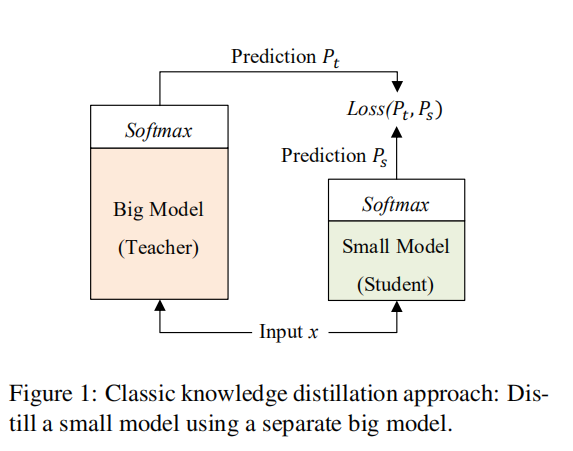

Knowledge distillation: Many attempts have been made to distill heavy models (teachers) into their lighter counterparts (students). PKD-BERT (Sun et al., 2019a) adopts an incremental extraction process that learns generalizations from intermediate layers of the teacher model. TinyBERT (Jiao et al., 2019) performs a two-stage learning involving both general-domain pre-training and taskspecific fine-tuning. DistilBERT (Sanh et al., 2019) further leveraged the inductive bias within large models by introducing a triple loss. As shown in Figure 1, student model often require a separated structure, whose effect however, depends mainly on the gains of the teacher. They are as indiscriminate to individual cases as their teachers, and only get faster in the cost of degraded performance.

知识蒸馏:人们已经做了许多尝试，试图将沉重的模型(教师)提炼为较轻的模型(学生)。PKD-BERT (Sun et al.， 2019a)采用增量提取过程，从教师模型的中间层学习归纳。TinyBERT (Jiao et al.， 2019)进行了两阶段学习，包括一般领域的预训练和任务特定的微调。DistilBERT (Sanh et al.， 2019)通过引入三重损失进一步利用了大型模型中的诱导偏差。如图1所示，学生模型通常需要一个单独的结构，但其效果主要取决于教师的收益。他们就像他们的老师一样，不分青红皂白地对待个别情况，而且只会以成绩下降为代价，越做越快。



Adaptive inference: Conventional approaches in adaptive computations are performed token-wise or patch-wise, who either adds recurrent steps to individual tokens (Graves, 2016) or dynamically adjusts the number of executed layers inside discrete regions of images (Teerapittayanon et al., 2016; Figurnov et al., 2017). To the best of our knowledge, there has been no work in applying adaptive mechanisms to NLP pre-training language models for efficiency improvements so far.

自适应推断:自适应计算中的常规方法是按tokens方式或按补丁方式执行的，它们要么向单个tokens添加循环步骤(Graves, 2016)，要么动态调整图像离散区域内执行的层数(Teerapittayanon et al.， 2016;Figurnov等人，2017)。据我们所知，迄今为止还没有人将自适应机制应用于NLP训练前语言模型以提高效率。

# 3 Methodology
# 3 方法

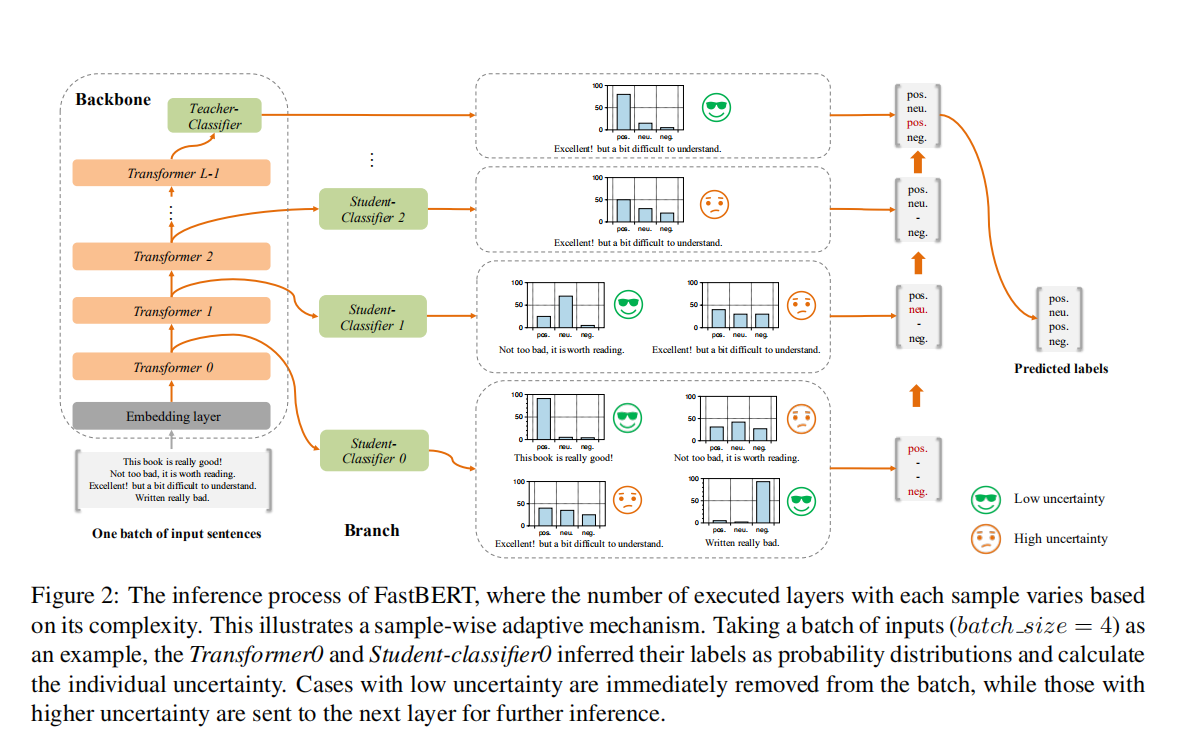

Distinct to the above efforts, our approach fusions the adaptation and distillation into a novel speed-up approach, shown in Figure 2, achieving competitive results in both accuracy and efficiency.

与上述努力不同，我们的方法融合了自适应和蒸馏到一个新的加速方法，如图2所示，在准确性和效率方面都获得了具有竞争力的结果。



## 3.1 Model architecture

## 3.1模型架构



As shown in Figure 2, FastBERT consists of backbone and branches. The backbone is built upon 12-layers Transformer encoder with an additional teacher-classifier, while the branches include student-classifiers which are appended to each Transformer output to enable early outputs.

如图2所示，FastBERT由主干和分支组成。主干是建立在12层Transformer编码器上的，带有一个额外的教师分类器，而分支包括学生分类器，这些学生分类器被附加到每个Transformer输出，以支持早期输出。



### 3.1.1 Backbone

### 3.1.1主干



The backbone consists of three parts: the embedding layer, the encoder containing stacks of Transformer blocks (Vaswani et al., 2017), and the teacher classifier. The structure of the embedding layer and the encoder conform with those of BERT (Devlin et al., 2019). Given the sentence length n, an input sentence s = [w0, w1, ...wn] will be transformed by the embedding layers to a sequence of vector representations e like (1), 

主干由三部分组成:嵌入层、包含Transformer块堆栈的编码器(Vaswani et al.， 2017)和教师分类器。嵌入层和编码器的结构与BERT (Devlin et al.， 2019)一致。给定句子长度n，输入句子s = [w0,w1,…,wn]将被嵌入层转换为向量表示序列e，如(1)，

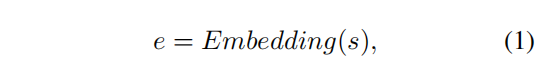

where e is the summation of word, position, and segment embeddings. Next, the transformer blocks in the encoder performs a layer-by-layer feature extraction as (2), 

其中e为词、位置和句子嵌入的总和。接下来，编码器中的变压器块按(2)进行逐层特征提取，

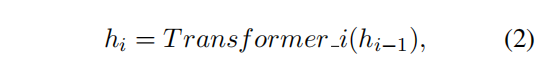

where hi (i = -1, 0, 1, ..., L-1) is the output features at the ith layer, and h-1 = e. L is the number of Transformer layers.

其中hi (i = - 1,0,1，…， L-1)为第i层的输出特征，h-1 = e. L为变压器层数。



Following the final encoding output is a teacher classifier that extracts in-domain features for downstream inferences. It has a fully-connected layer narrowing the dimension from 768 to 128, a self-attention joining a fully-connected layer without changes in vector size, and a fully-connected layer with a sof tmax function projecting vectors to an N-class indicator pt as in (3), where N is the taskspecific number of classes.

在最终的编码输出之后，是一个教师分类器，用于提取域内特征以进行下游推理。它有一个全链接层缩小尺寸从768维到128维,self-attention加入全层向量大小没有变化,和一个softmax函数投影向量一个N-class指标pt(3),其中N是特定任务数量的种类。

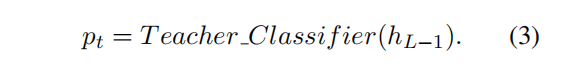

### 3.1.2 Branches

### 3.1.2分支



To provide FastBERT with more adaptability, multiple branches, i.e. the student classifiers, in the same architecture with the teacher are added to the output of each Transformer block to enable early outputs, especially in those simple cases. The student classifiers can be described as (4),

为了使FastBERT具有更强的适应性，在每个Transformer块的输出中都添加了多个分支，即学生分类器，以支持早期输出，特别是在那些简单的情况下。学生分类器可以描述为(4)，

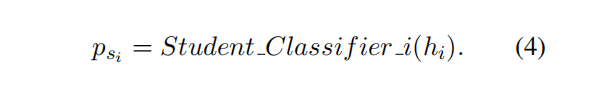

The student classifier is designed carefully to balance model accuracy and inference speed, for simple networks may impair the performance, while a heavy attention module severely slows down the inference speed. Our classifier has proven to be lighter with ensured competitive accuracy, detailed verifications are showcased in Section 4.1.

学生分类器是精心设计的，以平衡模型精度和推理速度，因为简单的网络可能会损害性能，而一个沉重的注意模块严重减慢推理速度。我们的分类器已经被证明是更轻的，具有确保竞争的准确性，详细的验证在第4.1节中展示。



## 3.2 Model training 

## 3.2模型的训练



FastBERT requires respective training steps for the backbone and the student classifiers. The parameters in one module is always frozen while the other module is being trained. The model is trained in preparation for downstream inference with three steps: the major backbone pre-training, entire backbone fine-tuning, and self-distillation for student classifiers.

FastBERT要求对主干和学生分类器进行相应的训练步骤。一个模块中的参数总是被冻结，而另一个模块则被训练。该模型通过三个步骤进行训练，为后续推理做准备:主要的主干预训练、整个主干微调和学生分类器的自蒸馏。



### 3.2.1 Pre-training

### 3.2.1 预训练



The pre-training of backbone resembles that of BERT in the same way that our backbone resembles BERT. Any pre-training method used for BERT-like models (e.g., BERT-WWM (Cui et al., 2019), RoBERTa (Liu et al., 2019), and ERNIE (Sun et al., 2019b)) can be directly applied. Note that the teacher classifier, as it is only used for inference, stays unaffected at this time. Also conveniently, FastBERT does not even need to perform pre-training by itself, for it can load high-quality pre-trained models freely.

骨干的预训练类似于BERT的训练，就像我们的骨干像BERT一样。任何针对类BERT模型(例如，BERT-WWM (Cui et al.， 2019)、RoBERTa (Liu et al.， 2019)和ERNIE (Sun et al.， 2019b))的预训练方法都可以直接应用。请注意，由于教师分类器仅用于推理，因此此时不受影响。同样方便的是，FastBERT甚至不需要自己进行预训练，因为它可以自由加载高质量的预训练模型。



### 3.2.2 Fine-tuning for backbone

### 3.2.2主干的微调



For each downstream task, we plug in the taskspecific data into the model, fine-tuning both the major backbone and the teacher classifier. The structure of the teacher classifier is as previously described. At this stage, all student classifiers are not enabled.

对于每个下游任务，我们将特定于任务的数据插入到模型中，对主要的主干和教师分类器进行微调。教师分类器的结构如前所述。在此阶段，不启用所有学生分类器。



### 3.2.3 Self-distillation for branch

### 3.2.3 分支自蒸馏



With the backbone well-trained for knowledge extraction, its output, as a high-quality soft-label containing both the original embedding and the generalized knowledge, is distilled for training student classifiers. As student are mutually independent, their predictions ps are compared with the teacher soft-label pt respectively, with the differences measured by KL-Divergence in (5),

通过对主干进行良好的知识提取训练，将其输出作为包含原始嵌入和广义知识的高质量软标签进行提取，用于训练学生分类器。由于学生是相互独立的，他们的预测ps分别与教师的软标签pt进行比较，其差异由式(5)中的KL散度度量，

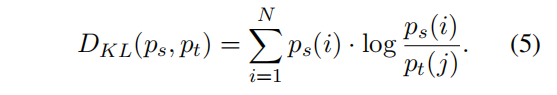

As there are L-1 student classifiers in the FastBERT, the sum of their KL-Divergences is used as the total loss for self-distillation, which is formulated in (6), 

由于FastBERT中有L-1个学生分类器，其KL散度之和作为自蒸馏出的总损失，如式(6)所示，

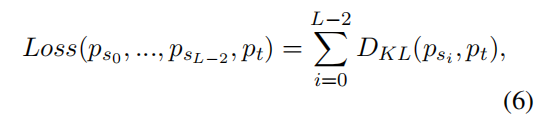

where psi refers to the probability distribution of the output from student-classifier i.

其中psi为学生分类器i输出的概率分布。



Since this process only requires the teachers output, we are free to use an unlimited number of unlabeled data, instead of being restricted to the labeled ones. This provides us with sufficient resources for self-distillation, which means we can always improve the student performance as long as the teacher allows. Moreover, our method differs from the previous distillation method, for the teacher and student outputs lie within the same model. This learning process does not require additional pretraining structures, making the distillation entirely a learning process by self.

因为这个过程只需要教师的输出，我们可以自由地使用无限数量的未标记的数据，而不是被限制在标记的数据中。这为我们提供了足够的自蒸馏的资源，这意味着只要老师允许，我们总是可以提高学生的表现。此外，我们的方法与之前的蒸馏方法不同，因为教师和学生的输出在同一个模型中。这个学习过程不需要额外的训练前结构，使蒸馏完全是一个自我学习过程。



## 3.3 Adaptive inference

## 3.3自适应推理



With the above steps, FastBERT is well-prepared to perform inference in an adaptive manner, which means we can adjust the number of executed encoding layers within the model according to the sample complexity.

通过以上步骤，FastBERT可以很好地以自适应的方式执行推断，这意味着我们可以根据样本的复杂性调整模型中执行的编码层的数量。



At each Transformer layer, we measure for each sample on whether the current inference is credible enough to be terminated.

在每个Transformer层，我们测量每个样本的当前推断是否足够可信，以终止。



Given an input sequence, the uncertainty of a student classifier’s output ps is computed with a normalized entropy in (7), 

给定一个输入序列，用(7)中的归一化熵计算学生分类器输出ps的不确定性，

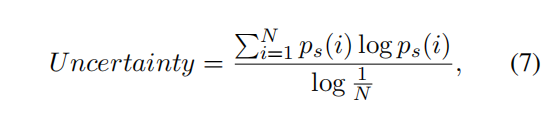

where ps is the distribution of output probability, and N is the number of labeled classes.

式中，ps为输出概率分布，N为标记类数。



With the definition of the uncertainty, we make an important hypothesis.

利用不确定性的定义，我们做了一个重要的假设。



Hypothesis 1. LUHA: the Lower the Uncertainty, the Higher the Accuracy.

假设1。LUHA:不确定度越低，准确度越高。



Definition 1. Speed: The threshold to distinguish high and low uncertainty. 

定义1。Speed:区分高不确定性和低不确定性的阈值。



LUHA is verified in Section 4.4. Both Uncertainty and Speed range between 0 and 1. The adaptive inference mechanism can be described as: At each layer of FastBERT, the corresponding student classifier will predict the label of each sample with measured Uncertainty. Samples with Uncertainty below the Speed will be sifted to early outputs, while samples with Uncertainty above the Speed will move on to the next layer.

LUHA在第4.4节中得到验证。不确定性和Speed都在0到1之间。自适应推理机制可以描述为:在FastBERT的每一层，对应的学生分类器将用测量的不确定性来预测每个样本的标签。Speed以下的不确定样本将被筛选到早期输出，Speed以上的不确定样本将被筛选到下一层。



Intuitively, with a higher Speed, fewer samples will be sent to higher layers, and overall inference speed will be faster, and vice versa. Therefore, Speed can be used as a halt value for weighing the inference accuracy and efficiency.

直观地说，Speed越高，发送到更高层的样本就越少，总体推断速度也就越快，反之亦然。因此，速度可以作为衡量推理准确性和效率的停顿值。

# 4 Experimental results

# 4实验结果



In this section, we will verify the effectiveness of FastBERT on twelve NLP datasets (six in English and six in Chinese) with detailed explanations.

在本节中，我们将验证FastBERT在12个NLP数据集(6个英文数据集和6个中文数据集)上的有效性，并给出详细的解释。



## 4.1 FLOPs analysis 

## 4.1FLOPs分析



Floating-point operations (FLOPs) is a measure of the computational complexity of models, which indicates the number of floating-point operations that the model performs for a single process. The FLOPs has nothing to do with the model’s operating environment (CPU, GPU or TPU) and only reveals the computational complexity. Generally speaking, the bigger the model’s FLOPs is, the longer the inference time will be. With the same accuracy, models with low FLOPs are more efficient and more suitable for industrial uses.

浮点运算(FLOPs)是模型计算复杂度的一种度量，它指示模型为单个进程执行的浮点运算的个数。FLOPs与模型的运行环境(CPU、GPU或TPU)无关，只显示了计算复杂度。一般来说，模型FLOPs越大，推理时间就越长。在同样的精度下，低FLOPs的模型更有效，更适合工业应用。

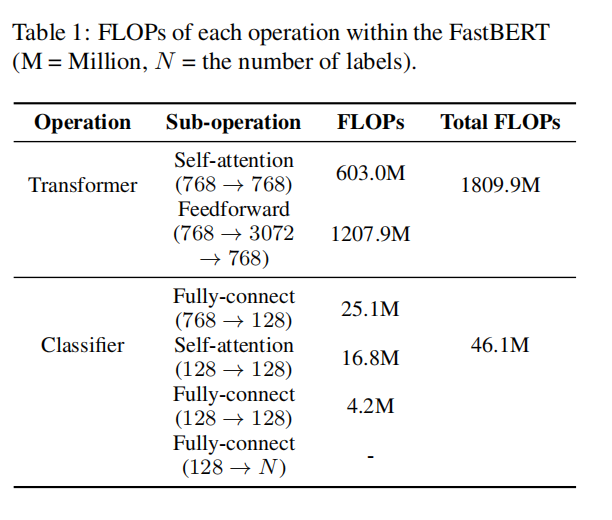

We list the measured FLOPs of both structures in Table 1, from which we can infer that, the calculation load (FLOPs) of the Classifier is much lighter than that of the Transformer. This is the basis of the speed-up of FastBERT, for although it adds additional classifiers, it achieves acceleration by reducing more computation in Transformers.

表1列出了两种结构的实测FLOPs值，从中可以看出Classifier(分类器)的计算负荷(FLOPs)比Transformer轻得多。这是FastBERT加速的基础，因为尽管它增加了额外的分类器，但是它通过减少Transformers的计算来实现加速。



## 4.2 Baseline and dataset

## 4.2基线和数据集



### 4.2.1 Baseline

### 4.2.1基线准备



In this section, we compare FastBERT against two baselines: 

在本节中，我们将FastBERT与两个基线进行比较:



• BERT The 12-layer BERT-base model was pre-trained on Wiki corpus and released by Google (Devlin et al., 2019). 

• BERT 12层的BERT-base模型在Wiki语料库上进行了预训练，由谷歌(Devlin et al.， 2019)。



• DistilBERT The most famous distillation method of BERT with 6 layers was released by Huggingface (Sanh et al., 2019). In addition, we use the same method to distill the DistilBERT with 3 and 1 layer(s), respectively.

• DistilBERT Huggingface (Sanh et al.， 2019)发布了BERT最著名的6层蒸馏方法。此外，我们使用相同的方法分别来提取含有3层和1层的DistilBERT。



### 4.2.2 Dataset

### 4.2.2数据集



To verify the effectiveness of FastBERT, especially in industrial scenarios, six Chinese and six English datasets pressing closer to actual applications are used. The six Chinese datasets include the sentence classification tasks (ChnSentiCorp, Book review(Qiu et al., 2018), Shopping review, Weibo and THUCNews) and a sentences-matching task (LCQMC(Liu et al., 2018)). All the Chinese datasets are available at the FastBERT project. The six English datasets (Ag.News, Amz.F, DBpedia, Yahoo, Yelp.F, and Yelp.P) are sentence classification tasks and were released in (Zhang et al., 2015).

为了验证FastBERT的有效性，特别是在工业场景中，我们使用了6个中文和6个英文数据集，这些数据集更贴近实际应用。这六个中文数据集包括句子分类任务(ChnSentiCorp, Book review(Qiu et al.， 2018)，购物评论，微博和清华新闻)和句子匹配任务(LCQMC (Liu et al.， 2018))。所有的中文数据集都可以在FastBERT项目中找到。六个英文数据集(Ag.News, Amz.F, DBpedia, Yahoo, Yelp.F, and Yelp.PP)是句子分类任务，在(Zhang et al.， 2015)中发布。



## 4.3 Performance comparison

## 4.3性能比较



To perform a fair comparison, BERT / DistilBERT / FastBERT all adopt the same configuration as follows. In this paper, L = 12. The number of self-attention heads, the hidden dimension of embedding vectors, and the max length of the input sentence are set to 12, 768 and 128 respectively. Both FastBERT and BERT use pre-trained parameters provided by Google, while DistilBERT is pretrained with (Sanh et al., 2019). We fine-tune these models using the AdamW (Loshchilov and Hutter) algorithm, a 2 × 10^-5 learning rate, and a 0.1 warmup. Then, we select the model with the best accuracy in 3 epochs. For the self-distillation of FastBERT, we increase the learning rate to 2×10^-4 and distill it for 5 epochs.

为了进行公平的比较，BERT / DistilBERT / FastBERT都采用相同的配置，如下所示。在本文中，L = 12。将self-attention heads的个数、嵌入向量的隐藏维数和输入语句的最大长度分别设置为12、768和128。FastBERT和BERT都使用谷歌提供的预训练参数，而DistilBERT使用预训练参数(Sanh et al.， 2019)。我们使用AdamW (Loshchilov和Hutter)算法对这些模型进行微调，2×10^-5的学习率和0.1的预热。然后，我们选择了3个epoch中精度最好的模型。对于FastBERT的自蒸馏，我们将学习率提高到2×10^-4，蒸馏5个周期。

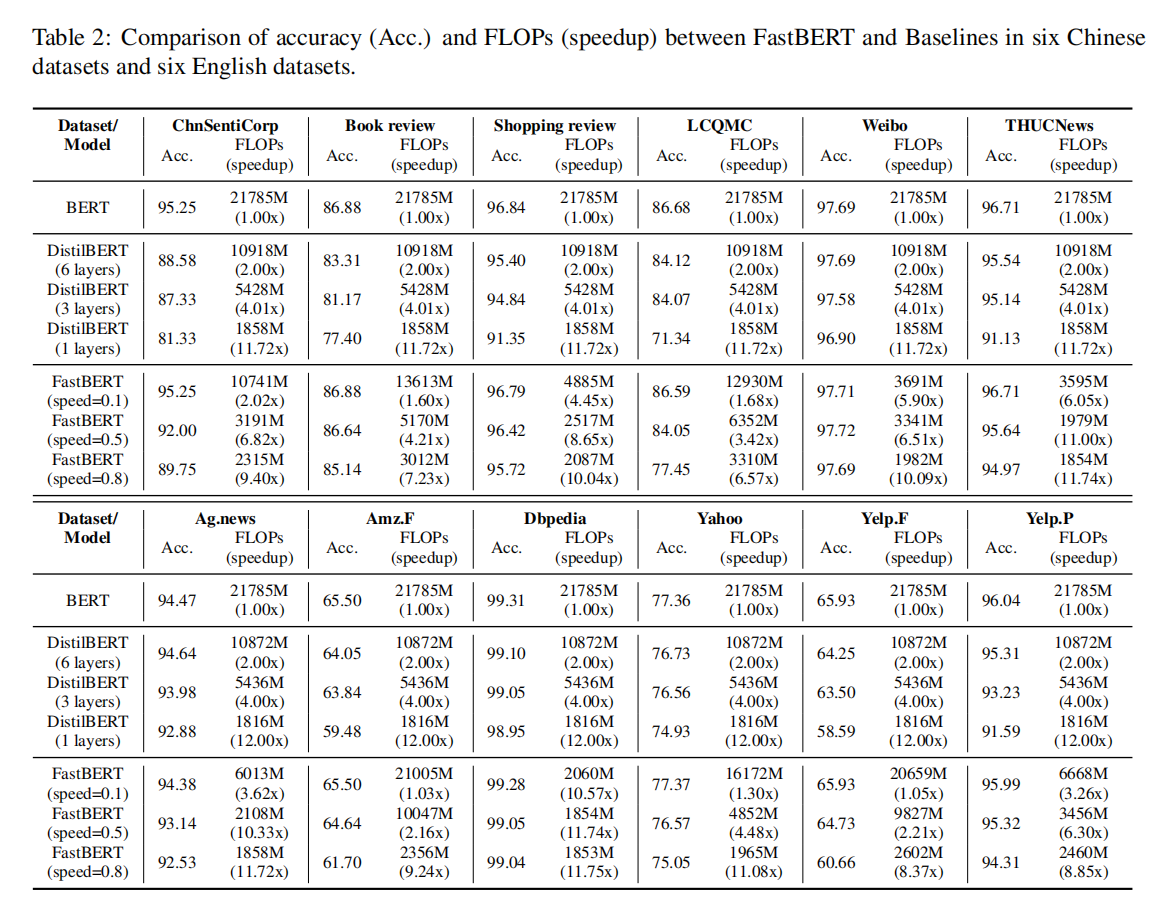

We evaluate the text inference capabilities of these models on the twelve datasets and report their accuracy (Acc.) and sample-averaged FLOPs under different Speed values. The result of comparisons are shown in Table 2, where the Speedup is obtained by using BERT as the benchmark. It can be observed that with the setting of Speed = 0.1, FastBERT can speed up 2 to 5 times without losing accuracy for most datasets. If a little loss of accuracy is tolerated, FastBERT can be 7 to 11 times faster than BERT. Comparing to DistilBERT, FastBERT trades less accuracy to catch higher ef- ficiency. Figure 3 illustrates FastBERT’s tradeoff in accuracy and efficiency. The speedup ratio of FastBERT are free to be adjusted between 1 and 12, while the loss of accuracy remains small, which is a very attractive feature in the industry.

我们评估了这些模型在12个数据集上的文本推理能力，并报告了它们在不同速度值下的准确性(Acc.)和样本平均FLOPs。比较结果如表2所示，其中以BERT为基准得到加速比。可以看出，在Speed = 0.1的情况下，FastBERT可以加速2到5倍，而不会丢失大部分数据集的精度。如果允许有一点点误差，FastBERT比BERT快7到11倍。与DistilBERT相比，FastBERT以较少的精度换取更高的效率。图3展示了FastBERT在准确性和效率上的权衡。FastBERT的加速比可以在1 - 12之间自由调整，但精度损失很小，这在行业中是一个非常吸引人的特点。


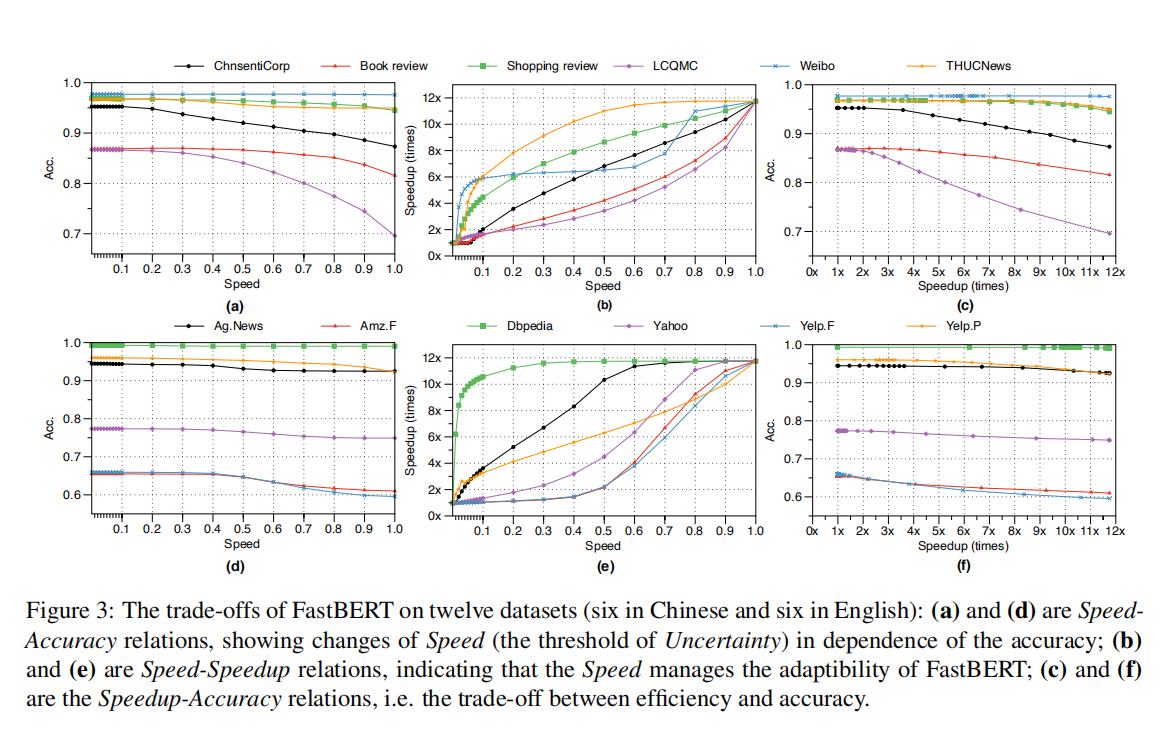


## 4.4 LUHA hypothesis verification

## 4.4 LUHA假设验证



As is described in the Section 3.3, the adaptive inference of FastBERT is based on the LUHA hypothesis, i.e., “the Lower the Uncertainty, the Higher the Accuracy”. Here, we prove this hypothesis using the book review dataset. We intercept the classification results of Student-Classifier0, StudentClassifier5, and Teacher-Classifier in FastBERT, then count their accuracy in each uncertainty interval statistically. As shown in Figure 4, the statistical indexes confirm that the classifier follows the LUHA hypothesis, no matter it sits at the bottom, in the middle or on top of the model.

如3.3节所述，FastBERT的自适应推理是基于LUHA假设，即，“不确定性越低，准确度越高”。在这里，我们使用book review数据集来证明这个假设。我们截取FastBERT中Student-Classifier0、student - classifier5和Teacher-Classifier的分类结果，然后统计每个不确定区间的准确率。如图4所示，统计指标证实分类器无论位于模型的底部、中间还是顶部，都遵循LUHA假设。

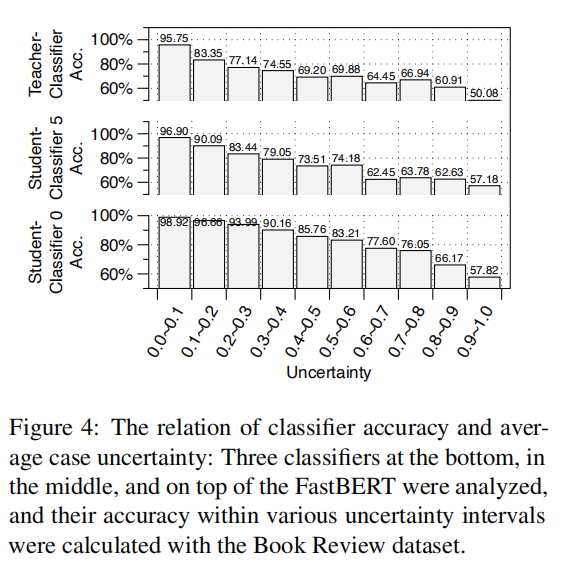

From Figure 4, it is easy to mistakenly conclude that Students has better performance than Teacher due to the fact that the accuracy of Student in each uncertainty range is higher than that of Teacher.

从图4可以看出，由于学生在每个不确定度范围内的准确性都高于教师，因此很容易得出学生比教师表现更好的结论。


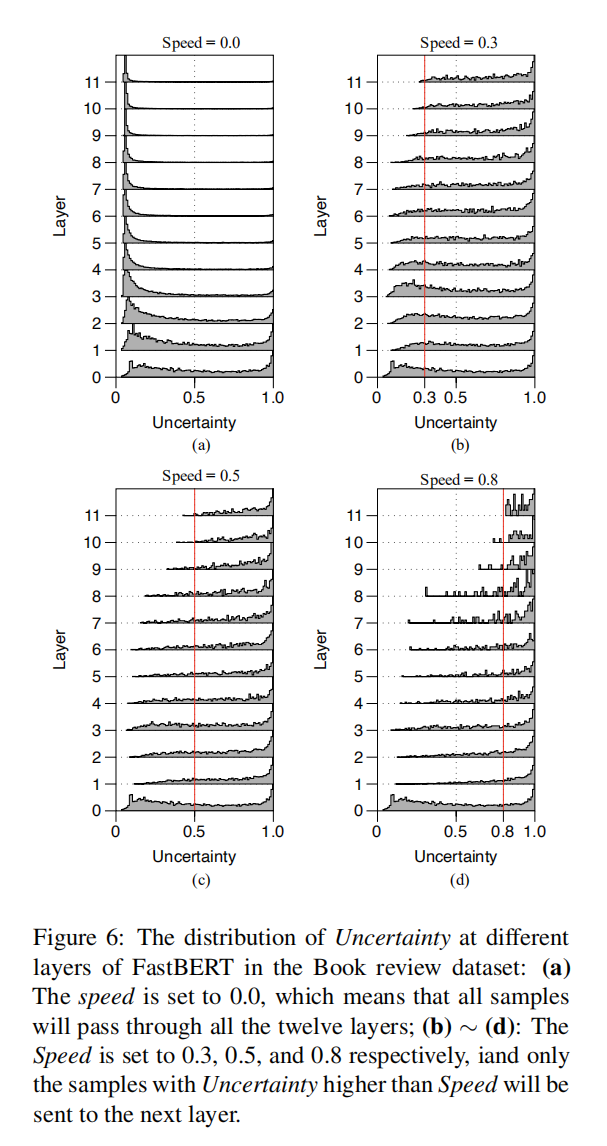

This conclusion can be denied by analysis with Figure 6(a) together. For the Teacher, more samples are located in areas with lower uncertainty, while the Students’ samples are nearly uniformly distributed. Therefore the overall accuracy of the Teacher is still higher than that of Students.

这个结论可以通过分析图6 (a)加以否定。对于教师来说，样本更多的分布在不确定性较小的区域，而学生的样本几乎是均匀分布的。因此，教师的总体准确性仍然高于学生。



## 4.5 In-depth study

## 4.5深入研究



In this section, we conduct a set of in-depth analysis of FastBERT from three aspects: the distribution of exit layer, the distribution of sample uncertainty, and the convergence during self-distillation.

在本节中，我们从出口层的分布、样本不确定性的分布以及自蒸馏过程的收敛性三个方面对FastBERT进行了一组深入的分析。



### 4.5.1 Layer distribution

### 4.5.1层分布

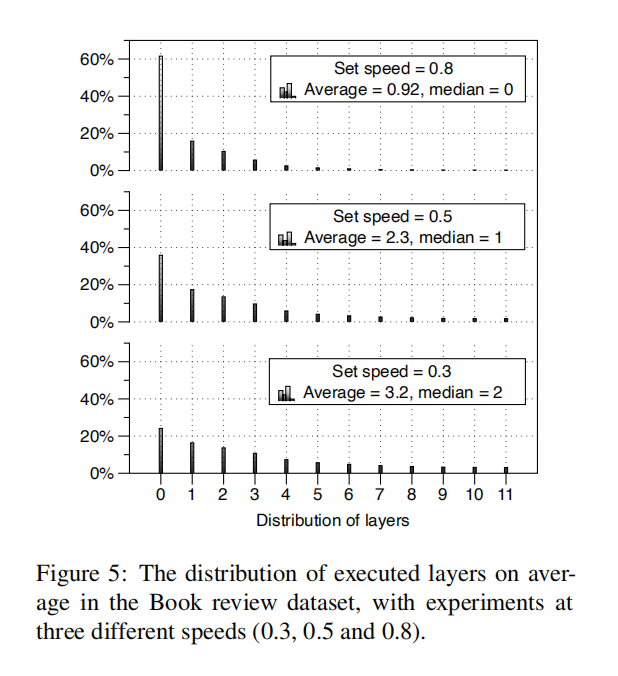

In FastBERT, each sample walks through a different number of Transformer layers due to varied complexity. For a certain condition, fewer executed layers often requires less computing resources. As illustrated in Figure 5, we investigate the distribution of exit layers under different constraint of Speeds (0.3, 0.5 and 0.8) in the book review dataset. Take Speed = 0.8 as an example, at the first layer Transformer0, 61% of the samples is able to complete the inference. This significantly eliminates unnecessary calculations in the next eleven layers.

在FastBERT中，由于复杂性的不同，每个示例都要遍历不同数量的Transformer层。对于特定的条件，较少的执行层通常需要较少的计算资源。如图5所示，我们研究了book review数据集中不同速度约束(0.3、0.5和0.8)下的出口层分布。以Speed = 0.8为例，在第一层Transformer0中，61%的样本能够完成推理。这极大地消除了接下来11层中不必要的计算。



### 4.5.2 Uncertainty distribution

### 4.5.2不确定性分布



The distribution of sample uncertainty predicted by different student classifiers varies, as is illustrated in Figure 6. Observing these distributions help us to further understand FastBERT. From Figure 6(a), it can be concluded that the higher the layer is posited, the lower the uncertainty with given Speed will be, indicating that the high-layer classifiers more decisive than the lower ones. It is worth noting that at higher layers, there are samples with uncertainty below the threshold of Uncertainty (i.e., the Speed), for these high-layer classifiers may reverse the previous judgments made by the low-layer classifiers.

不同学生分类器预测的样本不确定度分布不同，如图6所示。观察这些分布有助于我们进一步理解FastBERT。从图6(a)可以看出，层的位置越高，给定Speed下的不确定度越低，说明高层分类器比低层分类器更具有决定性。值得注意的是，在较高的层中，存在不确定度低于阈值的样本(即，对于这些高层分类器可能会推翻之前由低层分类器做出的判断。



### 4.5.3 Convergence of self-distillation 
### 4.5.3自蒸馏的收敛

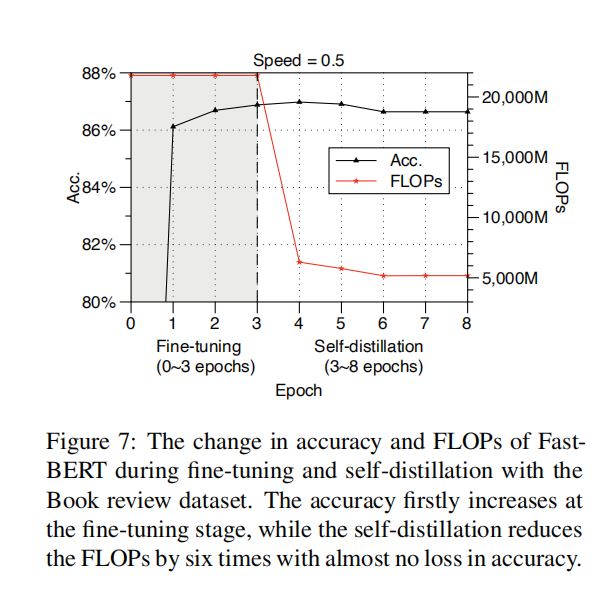

Self-distillation is a crucial step to enable FastBERT. This process grants student classifiers with the abilities to infer, thereby offloading work from the teacher classifier. Taking the Book Review dataset as an example, we fine-tune the FastBERT with three epochs then self-distill it for five more epochs. Figure 7 illustrates its convergence in accuracy and FLOPs during fine-tune and selfdistillation. It could be observed that the accuracy increases with fine-tuning, while the FLOPs decrease during the self-distillation stage.

自蒸馏是实现FastBERT的关键步骤。这个过程赋予学生分类器推断的能力，从而减轻教师分类器的工作量。以Book Review数据集为例，我们先用三轮对FastBERT进行微调，然后再用五轮对其进行自提取。图7显示了它在精度上的收敛性，以及在微调和自蒸馏过程中的失败。可以看出，在自精馏过程中，随着精馏过程的进行，精馏过程的精度随着精馏过程的进行而提高，而在精馏过程中，由于精馏过程的不断进行，使得精馏过程的准确度降低。



## 4.6 Ablation study

## 4.6消融研究

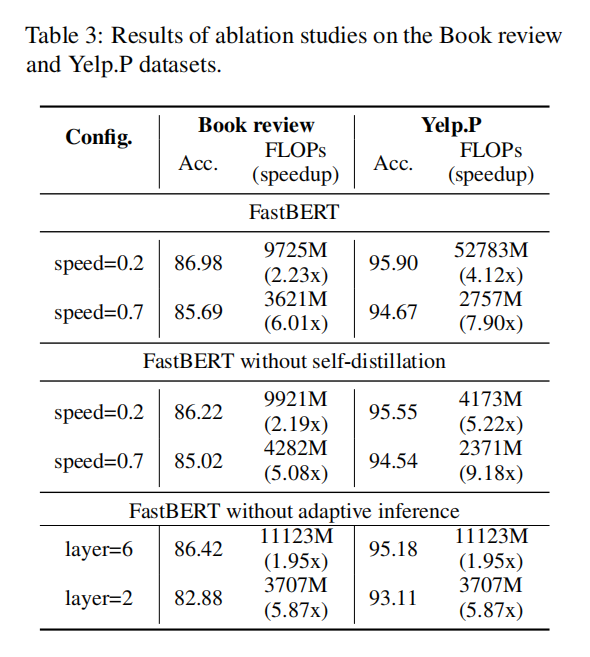

Adaptation and self-distillation are two crucial mechanisms in FastBERT. We have preformed ablation studies to investigate the effects brought by these two mechanisms using the Book Review dataset and the Yelp.P dataset. The results are presented in Table 3, in which ‘without selfdistillation’ implies that all classifiers, including both the teacher and the students, are trained in the fine-tuning; while ‘without adaptive inference’ means that the number of executed layers of each sample is fixated to two or six.

自适应和自蒸馏是FastBERT的两个关键机制。我们已经利用Book Review数据集和Yelp.P数据集进行了消融研究，以调查这两种机制带来的影响。结果如表3所示，其中“不用自蒸馏”意味着包括教师和学生在内的所有分类者都接受了微调训练;而“没有自适应推理”意味着每个样本的执行层数被固定在两个或六个。



From Table 3, we have observed that: (1) At almost the same level of speedup, FastBERT without self-distillation or adaption performs poorer; (2) When the model is accelerated more than five times, downstream accuracy degrades dramatically without adaption. It is safe to conclude that both the adaptation and self-distillation play a key role in FastBERT, which achieves both significant speedups and favorable low losses of accuracy.

由表3可以看出:(1)在几乎相同的加速水平下，没有自蒸馏或自适应的FastBERT性能较差;(2)当模型加速超过5倍时，不进行自适应，下游精度急剧下降。可以肯定地说，自适应和自蒸馏都在FastBERT中起着关键作用，它既能显著地加速，又能较好地降低精度损失。

# 5 Conclusion

# 5 结论



In this paper, we propose a fast version of BERT, namely FastBERT. Specifically, FastBERT adopts a self-distillation mechanism during the training phase and an adaptive mechanism in the inference phase, achieving the goal of gaining more effi- ciency with less accuracy loss. Self-distillation and adaptive inference are first introduced to NLP model in this paper. In addition, FastBERT has a very practical feature in industrial scenarios, i.e., its inference speed is tunable.

在本文中，我们提出了一个BERT的快速版本，即FastBERT。其中，FastBERT在训练阶段采用自蒸馏机制，在推理阶段采用自适应机制，以达到提高效率、减少精度损失的目的。本文首先将自蒸馏和自适应推理引入NLP模型。此外，FastBERT在工业场景中有一个非常实用的特性，即，其推理速度可调。



Our experiments demonstrate promising results on twelve NLP datasets. Empirical results have shown that FastBERT can be 2 to 3 times faster than BERT without performance degradation. If we slack the tolerated loss in accuracy, the model is free to tune its speedup between 1 and 12 times. Besides, FastBERT remains compatible to the parameter settings of other BERT-like models (e.g., BERTWWM, ERNIE, and RoBERTa), which means these public available models can be readily loaded for FastBERT initialization.

我们的实验在12个NLP数据集上证明了有希望的结果。实证结果表明，在没有性能下降的情况下，FastBERT比BERT快2到3倍。如果我们放松精度上的容许损失，模型可以自由地在1到12倍之间调整它的加速。此外，FastBERT仍然兼容其他类似于bert的模型(如BERTWWM、ERNIE和RoBERTa)的参数设置，这意味着这些公共可用的模型可以很容易地加载以进行FastBERT初始化。

# 6 Future work

# 6未来的工作



These promising results point to future works in (1) linearizing the Speed-Speedup curve; (2) extending this approach to other pre-training architectures such as XLNet (Yang et al., 2019) and ELMo (Peters et al., 2018); (3) applying FastBERT on a wider range of NLP tasks, such as named entity recognition and machine translation.

这些有希望的结果指向(1)线性化速度-加速曲线的未来工作;(2)将该方法扩展到其他训练前架构，如XLNet (Yang et al.， 2019)和ELMo (Peters et al.， 2018);(3)将FastBERT应用于更广泛的NLP任务，如命名实体识别和机器翻译。

Acknowledgments

致谢



This work is funded by 2019 Tencent Rhino-Bird Elite Training Program. Work done while this author was an intern at Tencent.

该项目由2019腾讯犀牛鸟精英培训项目资助。本文作者在腾讯实习期间完成的工作。
